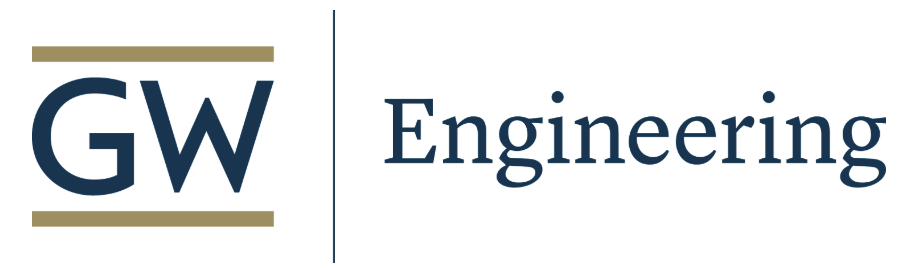

# **First Part: Reproducibility of Paper's methodologies and ML Techniques with synthetic data¶**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.pipeline import Pipeline
import seaborn as sns

In [13]:
# Step 1: Data preparation function
def prepare_data(data_path):
    """
    Load and prepare the dataset as described in the paper
    """
    try:
        # For this reproduction, we'll use a simulated dataset
        # In a real scenario, you would load the Microsoft Malware Prediction dataset
        print(f"In production, would load dataset from: {data_path}")

        # Simulate dataset based on paper description
        # The paper mentions 40,000 entries with 62 variables after cleaning
        n_samples = 1000  # Using smaller sample for demonstration

        # Creating synthetic data resembling the features described in the paper
        np.random.seed(42)

        # Input parameters (features)
        # Attack types and TTPs as described in the paper
        data = {
            # Attack types
            'malware_attack': np.random.randint(0, 2, n_samples),
            'spyware_attack': np.random.randint(0, 2, n_samples),
            'ransomware_attack': np.random.randint(0, 2, n_samples),
            'spear_phishing': np.random.randint(0, 2, n_samples),

            # TTPs
            'rootkit_usage': np.random.randint(0, 2, n_samples),
            'email_attachment': np.random.randint(0, 2, n_samples),
            'session_hijacking': np.random.randint(0, 2, n_samples),
            'xss_payload': np.random.randint(0, 2, n_samples),

            # System information (as mentioned in the dataset description)
            'firewall_enabled': np.random.randint(0, 2, n_samples),
            'antivirus_outdated': np.random.randint(0, 2, n_samples),
            'browser_vulnerable': np.random.randint(0, 2, n_samples),
            'has_tpm': np.random.randint(0, 2, n_samples)
        }

        # Output variables (targets)
        # Vulnerabilities and IoC as described in the paper

        # Create some correlation between features and targets to simulate real-world relationships
        vulnerability_prob = (0.7 * data['antivirus_outdated'] +
                             0.6 * data['browser_vulnerable'] +
                             0.5 * data['spear_phishing'] -
                             0.3 * data['firewall_enabled'] +
                             0.1 * np.random.randn(n_samples))

        ioc_prob = (0.6 * data['malware_attack'] +
                   0.7 * data['spyware_attack'] +
                   0.5 * data['rootkit_usage'] -
                   0.4 * data['firewall_enabled'] +
                   0.1 * np.random.randn(n_samples))
         # Convert to binary outcomes
        data['system_vulnerable'] = (vulnerability_prob > np.median(vulnerability_prob)).astype(int)
        data['ioc_detected'] = (ioc_prob > np.median(ioc_prob)).astype(int)

        # Create DataFrame
        df = pd.DataFrame(data)

        print(f"Dataset created with {df.shape[0]} samples and {df.shape[1]} features")
        print("Feature names:", df.columns.tolist())

        return df

    except Exception as e:
        print(f"Error preparing data: {e}")
        return None


In [14]:
# Step 2: Feature selection and engineering
def feature_engineering(df):
    """
    Select and transform features for model training
    """
    try:
        # In the paper, they selected 8 main features from 62
        # Here we'll use our simulated features

        # Input features (X) - attack types and TTPs
        input_features = ['malware_attack', 'spyware_attack', 'ransomware_attack', 'spear_phishing',
                         'rootkit_usage', 'email_attachment', 'session_hijacking', 'xss_payload',
                         'firewall_enabled', 'antivirus_outdated', 'browser_vulnerable', 'has_tpm']

        # Target variables (y) - vulnerabilities and IoC
        # For simplicity, we'll focus on system_vulnerable as the target
        target = 'system_vulnerable'

        X = df[input_features]
        y = df[target]

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Testing set: {X_test.shape[0]} samples")

        return X_train, X_test, y_train, y_test

    except Exception as e:
        print(f"Error in feature engineering: {e}")
        return None, None, None, None

In [15]:
# Step 3: Model training and evaluation
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate models following the paper's approach
    """
    try:
        # Initialize the classifiers mentioned in the paper
        classifiers = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Support Vector Machine': SVC(probability=True, random_state=42),
            'Random Forest': RandomForestClassifier(random_state=42),
            'Decision Tree': DecisionTreeClassifier(random_state=42)
        }

        results = {}

        # Train and evaluate each classifier
        for name, clf in classifiers.items():
            # Train the model
            clf.fit(X_train, y_train)

            # Predict on test set
            y_pred = clf.predict(X_test)

            # Calculate performance metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # Store results
            results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }

            # Calculate confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()

            print(f"\nResults for {name}:")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

            # Calculate and print TPR, FPR, etc. as done in the paper
            tpr = tp / (tp + fn)
            fpr = fp / (tn + fp)
            tnr = tn / (tn + fp)
            fnr = fn / (tp + fn)

            print(f"True Positive Rate (Recall): {tpr:.4f}")
            print(f"False Positive Rate: {fpr:.4f}")
            print(f"True Negative Rate: {tnr:.4f}")
            print(f"False Negative Rate: {fnr:.4f}")

        # Implement the Majority Voting as described in the paper
        voting_clf = VotingClassifier(
            estimators=[
                ('lr', classifiers['Logistic Regression']),
                ('svm', classifiers['Support Vector Machine']),
                ('rf', classifiers['Random Forest']),
                ('dt', classifiers['Decision Tree'])
            ],
            voting='soft'  # Use probability estimates for voting
        )

        voting_clf.fit(X_train, y_train)
        y_pred_voting = voting_clf.predict(X_test)

        # Calculate performance metrics for Majority Voting
        accuracy_voting = accuracy_score(y_test, y_pred_voting)
        precision_voting = precision_score(y_test, y_pred_voting)
        recall_voting = recall_score(y_test, y_pred_voting)
        f1_voting = f1_score(y_test, y_pred_voting)

        # Store results
        results['Majority Voting'] = {
            'accuracy': accuracy_voting,
            'precision': precision_voting,
            'recall': recall_voting,
            'f1_score': f1_voting
        }

        # Print Majority Voting results
        print("\nResults for Majority Voting:")
        print(f"Accuracy: {accuracy_voting:.4f}")
        print(f"Precision: {precision_voting:.4f}")
        print(f"Recall: {recall_voting:.4f}")
        print(f"F1 Score: {f1_voting:.4f}")

        return results, classifiers

    except Exception as e:
        print(f"Error in model training and evaluation: {e}")
        return None, None


In [16]:
# Step 4: ROC-AUC evaluation
def plot_roc_curves(classifiers, X_test, y_test):
    """
    Plot ROC curves for all classifiers, as shown in the paper
    """
    try:
        plt.figure(figsize=(10, 8))

        # Add Majority Voting to classifiers
        all_classifiers = classifiers.copy()
        all_classifiers['Majority Voting'] = VotingClassifier(
            estimators=[
                ('lr', classifiers['Logistic Regression']),
                ('svm', classifiers['Support Vector Machine']),
                ('rf', classifiers['Random Forest']),
                ('dt', classifiers['Decision Tree'])
            ],
            voting='soft'
        )
        all_classifiers['Majority Voting'].fit(X_train, y_train)

        colors = ['blue', 'green', 'red', 'orange', 'purple']

        for (name, clf), color in zip(all_classifiers.items(), colors):
            # For SVM, we need to get decision function
            if name == 'Support Vector Machine':
                y_score = clf.decision_function(X_test)
            else:
                y_score = clf.predict_proba(X_test)[:, 1]

            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.plot(fpr, tpr, color=color, lw=2,
                     label=f'{name} (AUC = {roc_auc:.2f})')

        # Plot diagonal line (random classifier)
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for All Classifiers')
        plt.legend(loc="lower right")

        return plt

    except Exception as e:
        print(f"Error plotting ROC curves: {e}")
        return None

In [17]:
# Step 5: Vulnerability prediction
def predict_vulnerabilities(best_model, input_data):
    """
    Use the best model to predict vulnerabilities for new data
    """
    try:
        # Prepare input data
        if isinstance(input_data, dict):
            input_df = pd.DataFrame([input_data])
        else:
            input_df = pd.DataFrame(input_data)

        # Make prediction
        prediction = best_model.predict(input_df)

        # Get probability
        probability = best_model.predict_proba(input_df)[:, 1]

        return {
            'vulnerable': bool(prediction[0]),
            'probability': float(probability[0])
        }

    except Exception as e:
        print(f"Error predicting vulnerabilities: {e}")
        return None


In [18]:
# Step 6: Run the complete pipeline
def run_cyber_threat_prediction():
    """
    Run the complete prediction pipeline
    """
    print("Starting Cyber Supply Chain Threat Prediction")
    print("=" * 50)

    # Step 1: Data preparation
    print("\nStep 1: Data Preparation")
    df = prepare_data("microsoft_malware_prediction.csv")

    if df is None:
        return

    # Step 2: Feature engineering
    print("\nStep 2: Feature Engineering")
    X_train, X_test, y_train, y_test = feature_engineering(df)

    if X_train is None:
        return

    # Step 3: Model training and evaluation
    print("\nStep 3: Model Training and Evaluation")
    results, classifiers = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    if results is None:
        return

    # Step 4: ROC-AUC evaluation
    print("\nStep 4: ROC-AUC Evaluation")
    plt = plot_roc_curves(classifiers, X_test, y_test)

    # Find the best model
    best_model_name = max(results, key=lambda k: results[k]['f1_score'])
    best_model = classifiers.get(best_model_name)

    print(f"\nBest model: {best_model_name}")
    print(f"Best model F1-score: {results[best_model_name]['f1_score']:.4f}")

    # Step 5: Predict vulnerabilities for a new sample
    print("\nStep 5: Predict Vulnerabilities for a New Sample")
    new_sample = {
        'malware_attack': 1,
        'spyware_attack': 0,
        'ransomware_attack': 1,
        'spear_phishing': 1,
        'rootkit_usage': 1,
        'email_attachment': 1,
        'session_hijacking': 0,
        'xss_payload': 0,
        'firewall_enabled': 0,
        'antivirus_outdated': 1,
        'browser_vulnerable': 1,
        'has_tpm': 0
    }

    prediction = predict_vulnerabilities(best_model, new_sample)

    print("\nPrediction for new sample:")
    print(f"Input: {new_sample}")
    print(f"Prediction: {'Vulnerable' if prediction['vulnerable'] else 'Not Vulnerable'}")
    print(f"Probability: {prediction['probability']:.4f}")

    # Display results summary
    print("\nResults Summary:")
    print("-" * 80)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
    print("-" * 80)

    for model, metrics in results.items():
        print(f"{model:<20} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} {metrics['f1_score']:<10.4f}")

    return {
        'results': results,
        'best_model': best_model,
        'best_model_name': best_model_name
    }

# Run the pipeline
if __name__ == "__main__":
    # Create synthetic data and run the prediction pipeline
    X_train = X_test = y_train = y_test = None  # Initialize variables used in functions
    output = run_cyber_threat_prediction()

Starting Cyber Supply Chain Threat Prediction

Step 1: Data Preparation
In production, would load dataset from: microsoft_malware_prediction.csv
Dataset created with 1000 samples and 14 features
Feature names: ['malware_attack', 'spyware_attack', 'ransomware_attack', 'spear_phishing', 'rootkit_usage', 'email_attachment', 'session_hijacking', 'xss_payload', 'firewall_enabled', 'antivirus_outdated', 'browser_vulnerable', 'has_tpm', 'system_vulnerable', 'ioc_detected']

Step 2: Feature Engineering
Training set: 700 samples
Testing set: 300 samples

Step 3: Model Training and Evaluation

Results for Logistic Regression:
Accuracy: 0.9633
Precision: 0.9419
Recall: 0.9865
F1 Score: 0.9637
Confusion Matrix: TN=143, FP=9, FN=2, TP=146
True Positive Rate (Recall): 0.9865
False Positive Rate: 0.0592
True Negative Rate: 0.9408
False Negative Rate: 0.0135

Results for Support Vector Machine:
Accuracy: 0.9633
Precision: 0.9419
Recall: 0.9865
F1 Score: 0.9637
Confusion Matrix: TN=143, FP=9, FN=2, TP=

<Figure size 1000x800 with 0 Axes>

# **Second Part: Empirical Comparative Study of Deep Learning Techniques**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import time

In [2]:
# Setting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

In [6]:
def prepare_synthetic_data(n_samples=5000):
    """Prepare synthetic data similar to what would be in the Microsoft Malware dataset"""
    # Input parameters (features)
    data = {
        # Attack types
        'malware_attack': np.random.randint(0, 2, n_samples),
        'spyware_attack': np.random.randint(0, 2, n_samples),
        'ransomware_attack': np.random.randint(0, 2, n_samples),
        'spear_phishing': np.random.randint(0, 2, n_samples),

        # TTPs
        'rootkit_usage': np.random.randint(0, 2, n_samples),
        'email_attachment': np.random.randint(0, 2, n_samples),
        'session_hijacking': np.random.randint(0, 2, n_samples),
        'xss_payload': np.random.randint(0, 2, n_samples),

        # System information
        'firewall_enabled': np.random.randint(0, 2, n_samples),
        'antivirus_outdated': np.random.randint(0, 2, n_samples),
        'browser_vulnerable': np.random.randint(0, 2, n_samples),
        'has_tpm': np.random.randint(0, 2, n_samples),

        # Additional features to make the dataset more complex
        'os_version': np.random.randint(0, 5, n_samples),  # 5 different OS versions
        'geolocation_id': np.random.randint(0, 10, n_samples),  # 10 different geolocations
        'user_privilege': np.random.randint(0, 3, n_samples),  # user privilege levels
        'network_segment': np.random.randint(0, 4, n_samples),  # network segments
        'firmware_version': np.random.randint(0, 3, n_samples),
        'connection_type': np.random.randint(0, 3, n_samples),
        'encryption_level': np.random.randint(0, 3, n_samples),
        'days_since_update': np.random.randint(0, 365, n_samples)
    }
     # Create correlations for target variable
    vulnerability_prob = (
        0.7 * data['antivirus_outdated'] +
        0.6 * data['browser_vulnerable'] +
        0.5 * data['spear_phishing'] +
        0.4 * data['rootkit_usage'] +
        0.3 * (data['os_version'] == 0) +  # older OS versions more vulnerable
        0.3 * (data['days_since_update'] > 180) -  # longer time since updates
        0.3 * data['firewall_enabled'] -
        0.2 * data['encryption_level'] -
        0.2 * (data['user_privilege'] == 0) +  # admin privileges more vulnerable
        0.1 * np.random.randn(n_samples)
    )

    # Create binary target
    data['system_vulnerable'] = (vulnerability_prob > np.median(vulnerability_prob)).astype(int)

    # Create DataFrame
    df = pd.DataFrame(data)

    print(f"Dataset created with {df.shape[0]} samples and {df.shape[1]} features")

    return df

In [7]:
def preprocess_data(df):
    """Preprocess data for model training"""
    # One-hot encode categorical variables
    df_processed = pd.get_dummies(df, columns=['os_version', 'geolocation_id', 'network_segment'])

    # Split features and target
    X = df_processed.drop('system_vulnerable', axis=1)
    y = df_processed['system_vulnerable']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, X.shape[1]

In [8]:
# 1. TensorFlow/Keras DNN Model
def build_tf_dnn(input_dim):
    """Build a TensorFlow/Keras DNN model"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:
def train_tf_dnn(X_train, y_train, X_test, y_test, input_dim):
    """Train and evaluate TensorFlow DNN model"""
    start_time = time.time()

    # Build model
    model = build_tf_dnn(input_dim)

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    training_time = time.time() - start_time

    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'training_time': training_time
    }

In [11]:
# 2. PyTorch DNN Model
class PyTorchDNN(nn.Module):
    """PyTorch Deep Neural Network"""
    def __init__(self, input_dim):
        super(PyTorchDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 32)

        self.output = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu(x)

        x = self.output(x)
        x = self.sigmoid(x)

        return x

def train_pytorch_dnn(X_train, y_train, X_test, y_test, input_dim):
    """Train and evaluate PyTorch DNN model"""
    start_time = time.time()

    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize model
    model = PyTorchDNN(input_dim)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    epochs = 50
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_indices = np.random.choice(len(X_train_tensor), size=len(X_train_tensor)//5, replace=False)
            X_val = X_train_tensor[val_indices]
            y_val = y_train_tensor[val_indices]
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Evaluate model
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_test_tensor).numpy().flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    training_time = time.time() - start_time

    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'training_time': training_time
    }